In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import datetime


In [82]:
# Load QB data
qb = pd.read_csv("C:/Users/Andy/Documents/VSCODE/qb_stats.csv")
rb = pd.read_csv("C:/Users/Andy/Documents/VSCODE/rb_stats.csv")
wrte = pd.read_csv("C:/Users/Andy/Documents/VSCODE/wrte_stats.csv")

# Transforming week variable to career_game_number
qb = qb.sort_values(by=['full_name', 'season', 'week']).reset_index(drop=True)
qb['career_game_number'] = qb.groupby('full_name').cumcount() + 1

rb = rb.sort_values(by=['full_name', 'season', 'week']).reset_index(drop=True)
rb['career_game_number'] = rb.groupby('full_name').cumcount() + 1

wrte = wrte.sort_values(by=['full_name', 'season', 'week']).reset_index(drop=True)
wrte['career_game_number'] = wrte.groupby('full_name').cumcount() + 1



In [83]:
# Define rolling function
def compute_rolling_epa(group):
    group = group.sort_values(by=['season', 'week'])
    group['epa_avg_last_1'] = group['avg_epa'].shift(1).rolling(window=1).mean()
    group['epa_avg_last_3'] = group['avg_epa'].shift(1).rolling(window=3).mean()
    group['epa_avg_last_5'] = group['avg_epa'].shift(1).rolling(window=5).mean()
    group['epa_std_last_5'] = group['avg_epa'].shift(1).rolling(window=5).std()
    return group

# Apply rolling computation per player
qb = qb.groupby('full_name').apply(compute_rolling_epa).reset_index(drop=True)
rb = rb.groupby('full_name').apply(compute_rolling_epa).reset_index(drop=True)
wrte = wrte.groupby('full_name').apply(compute_rolling_epa).reset_index(drop=True)

C:\Users\Andy\AppData\Local\Temp\ipykernel_6824\2489326987.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qb = qb.groupby('full_name').apply(compute_rolling_epa).reset_index(drop=True)
C:\Users\Andy\AppData\Local\Temp\ipykernel_6824\2489326987.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rb = rb.groupby('full_name').apply(compute_rolling_epa).reset_index(drop=True)
C:\Users\Andy\AppData\Local\

In [84]:
# Assigning Neutral Performance for NaN rolling averages
qb[['epa_avg_last_1', 'epa_avg_last_3', 'epa_avg_last_5', 'epa_std_last_5']] = \
    qb[['epa_avg_last_1', 'epa_avg_last_3', 'epa_avg_last_5', 'epa_std_last_5']].fillna(0)
qb.head()


,season,week,gsis_id,full_name,team,position,birth_date,height,weight,years_exp,...,penalty_yards,qb_dropback,total_epa,avg_epa,cpoe,career_game_number,epa_avg_last_1,epa_avg_last_3,epa_avg_last_5,epa_std_last_5
0,2018,9,00-0031288,AJ McCarron,OAK,QB,1990-09-13,75,220,4,...,0,4,-5.851232,-1.170246,21.733034,1,0.000000,0.000000,0.0,0.0
1,2018,12,00-0031288,AJ McCarron,OAK,QB,1990-09-13,75,220,4,...,0,0,0.000000,0.000000,NaN,2,-1.170246,0.000000,0.0,0.0
2,2019,11,00-0031288,AJ McCarron,HOU,QB,1990-09-13,75,220,5,...,0,2,-4.611414,-2.305707,-70.505351,3,0.000000,0.000000,0.0,0.0
3,2019,17,00-0031288,AJ McCarron,HOU,QB,1990-09-13,75,220,5,...,0,45,-3.037633,-0.067503,-4.193595,4,-2.305707,-1.158651,0.0,0.0
4,2020,14,00-0031288,AJ McCarron,HOU,QB,1990-09-13,75,220,6,...,0,1,-4.926011,-4.926011,NaN,5,-0.067503,-0.791070,0.0,0.0


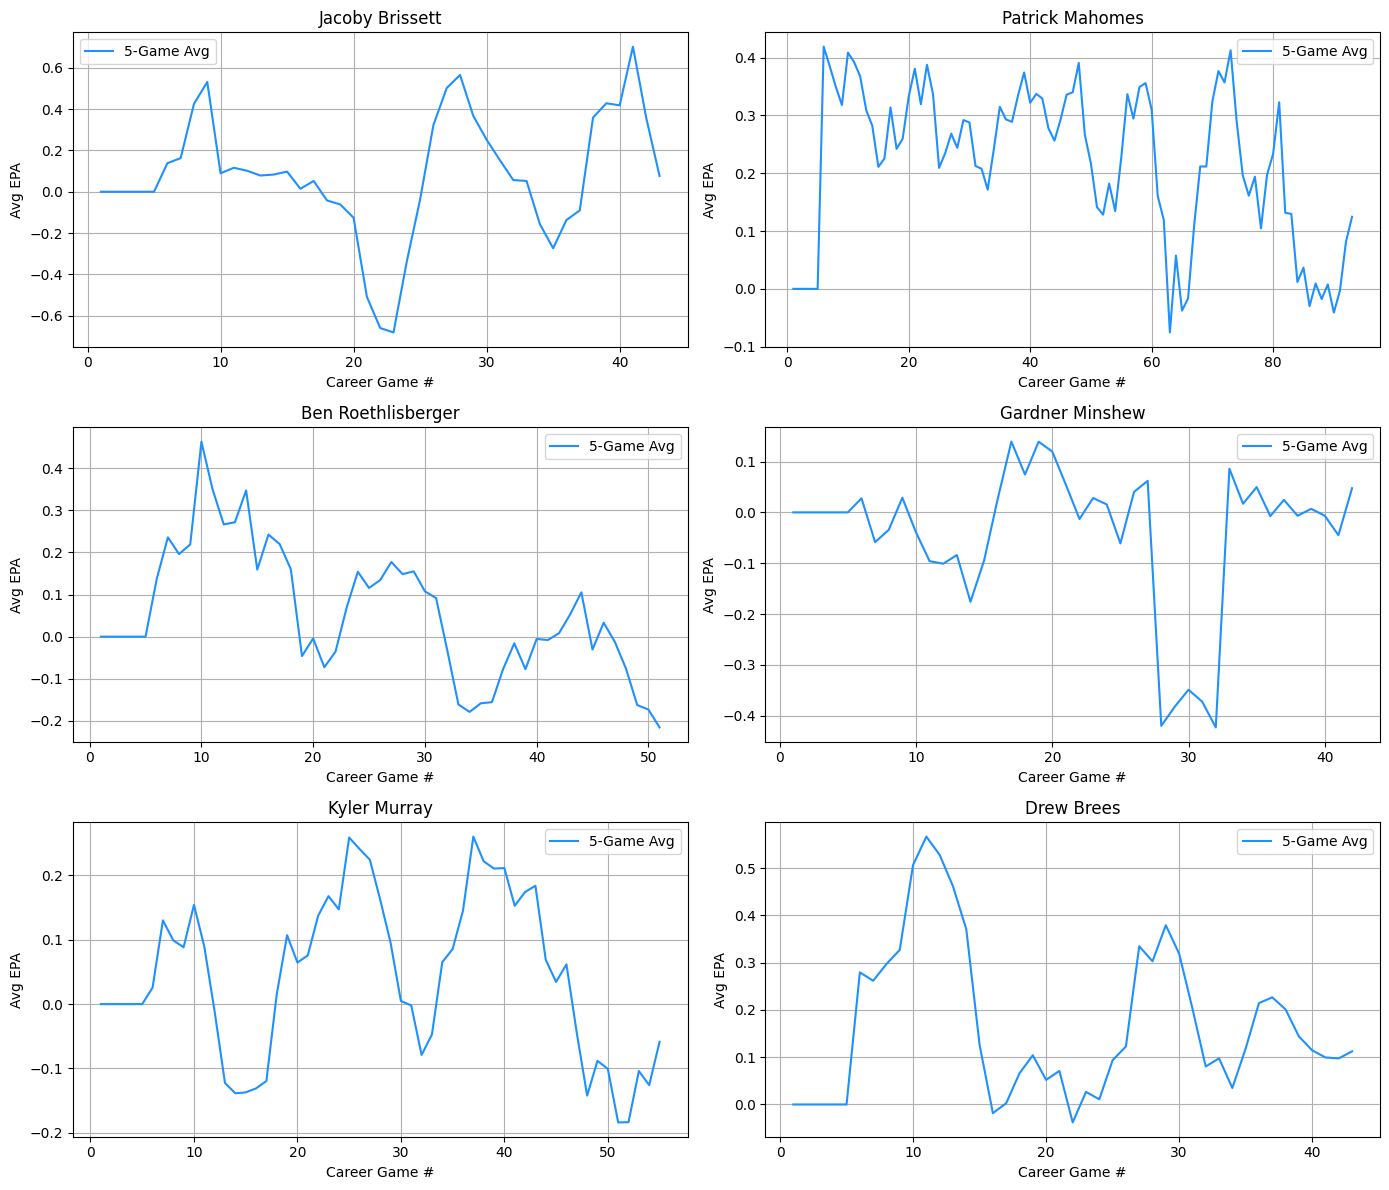

In [85]:
# Pick a subset of players who played at least 10 games
min_games = 10
player_counts = qb['full_name'].value_counts()
sample_players = player_counts[player_counts >= min_games].sample(6, random_state=42).index

fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.flatten()

for i, player in enumerate(sample_players):
    p_df = qb[qb['full_name'] == player]
    axs[i].plot(p_df['career_game_number'], p_df['epa_avg_last_5'], label='5-Game Avg', color='dodgerblue')
    axs[i].set_title(player)
    axs[i].set_xlabel("Career Game #")
    axs[i].set_ylabel("Avg EPA")
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()


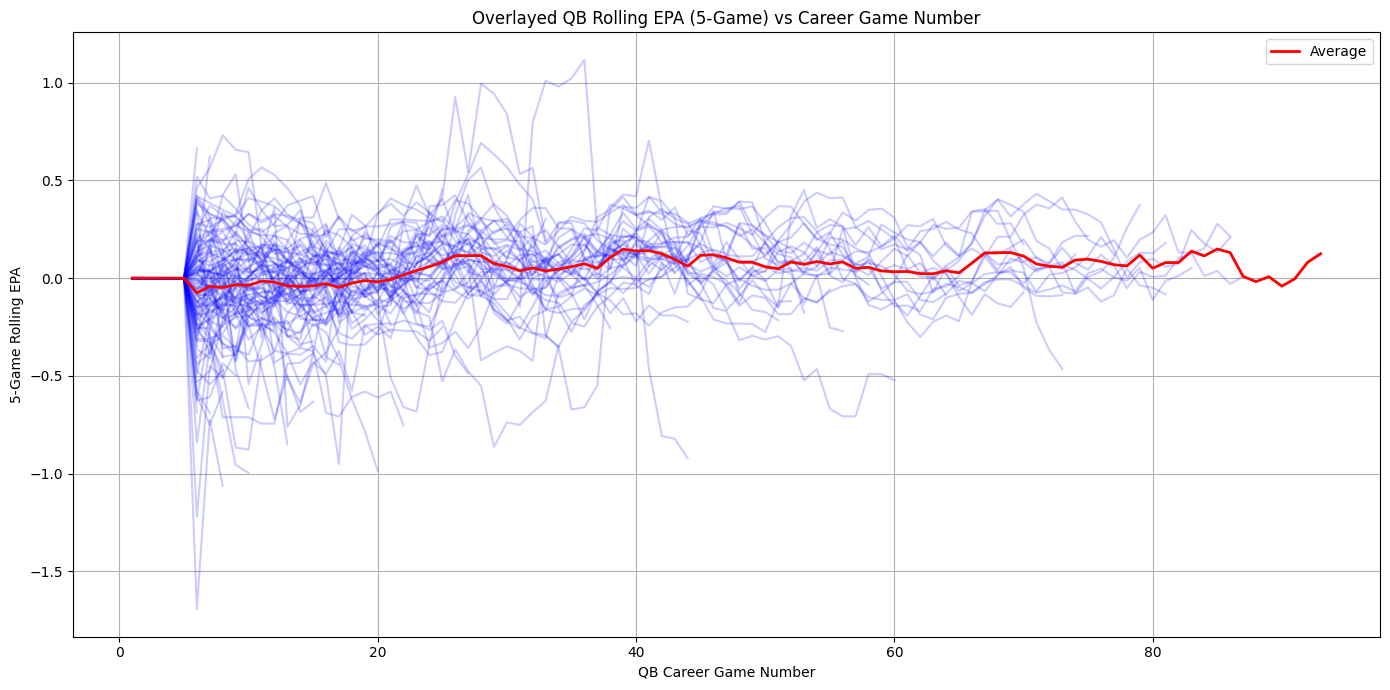

In [86]:
def rolling_epa_5(df, label):
    plt.figure(figsize=(14, 7))

    # Loop through each player and plot their 5-game rolling EPA curve
    for player, group in df.groupby('full_name'):
        plt.plot(group['career_game_number'], group['epa_avg_last_5'], alpha=0.2, color='blue')

    # Optionally overlay the average trend
    agg = df.groupby('career_game_number')['epa_avg_last_5'].mean()
    plt.plot(agg.index, agg.values, color='red', linewidth=2, label='Average')

    # Plot formatting
    plt.title(f"Overlayed {label} Rolling EPA (5-Game) vs Career Game Number")
    plt.xlabel(f"{label} Career Game Number")
    plt.ylabel("5-Game Rolling EPA")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
rolling_epa_5(qb, 'QB')

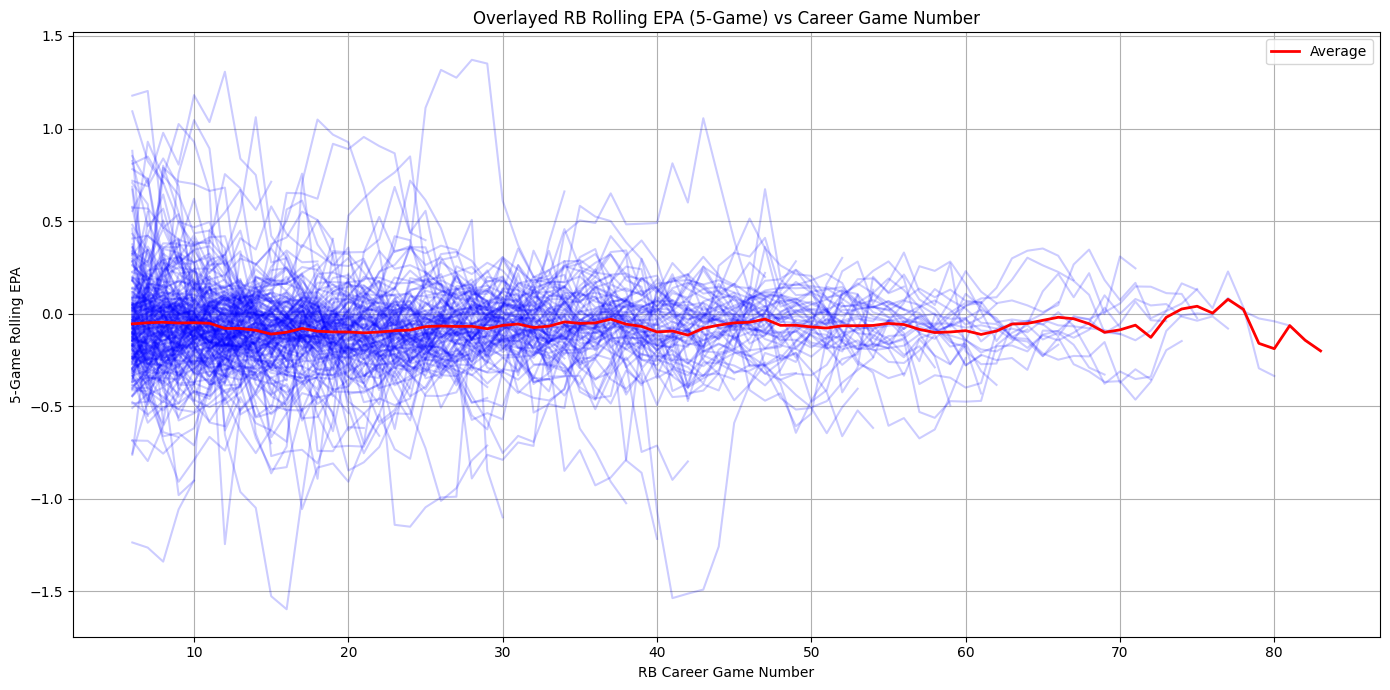

In [87]:
rolling_epa_5(rb, 'RB')

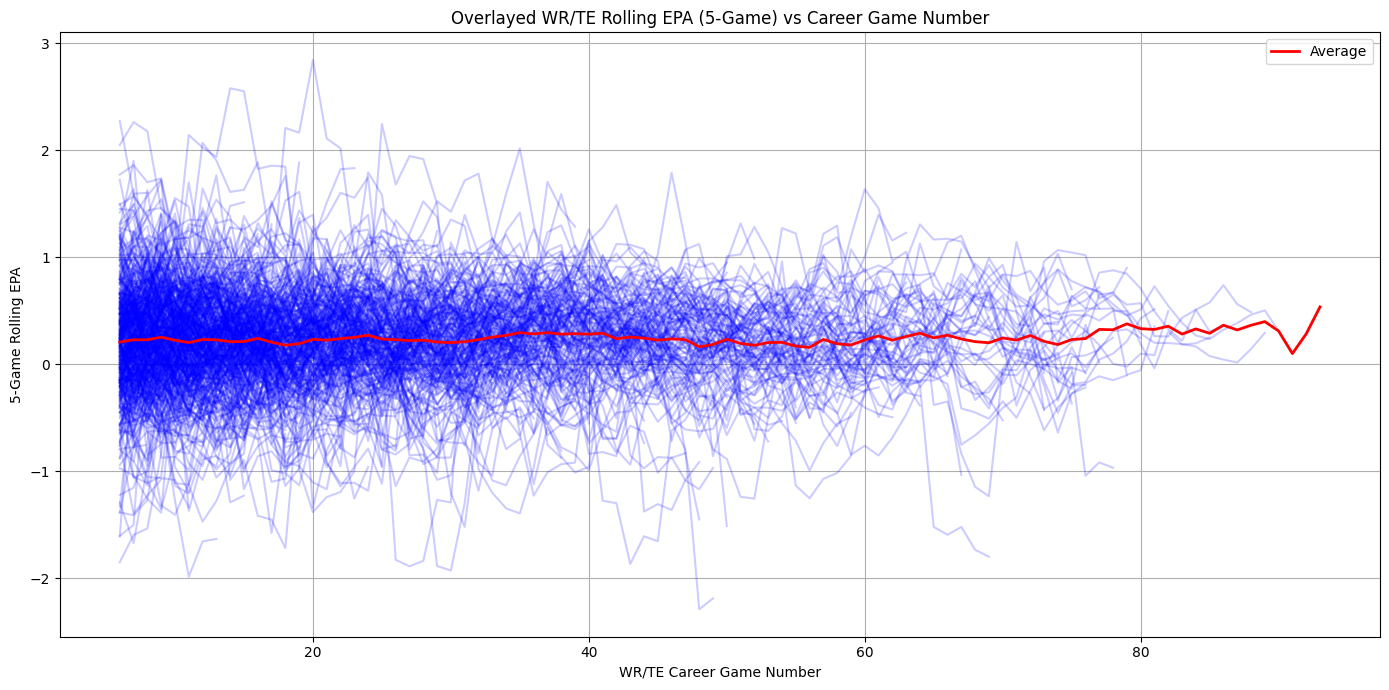

In [88]:
rolling_epa_5(wrte, 'WR/TE')

## Data Preparation

In [89]:
# Drop non-predictive columns
qb_features = qb.drop(columns=['avg_epa','gsis_id', 'position', 'depth_chart_position', 'full_name', 'week', 'total_epa', 'draft_number', 'third_down_rate', 'fourth_down_rate', 'entry_year'])
qb_features = pd.get_dummies(qb_features, columns=['team'])
qb_features


,season,birth_date,height,weight,years_exp,rookie_year,pass_attempts,completions,comp_pct,air_yards,...,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS
0,2018,1990-09-13,75,220,4,2014,4,1,400.000000,7,...,False,False,True,False,False,False,False,False,False,False
1,2018,1990-09-13,75,220,4,2014,0,0,NaN,0,...,False,False,True,False,False,False,False,False,False,False
2,2019,1990-09-13,75,220,5,2014,2,0,inf,0,...,False,False,False,False,False,False,False,False,False,False
3,2019,1990-09-13,75,220,5,2014,40,21,190.476190,95,...,False,False,False,False,False,False,False,False,False,False
4,2020,1990-09-13,75,220,6,2014,1,0,inf,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023,1999-08-03,74,208,2,2021,57,33,172.727273,145,...,False,True,False,False,False,False,False,False,False,False
3330,2023,1999-08-03,74,208,2,2021,41,23,178.260870,114,...,False,True,False,False,False,False,False,False,False,False
3331,2023,1999-08-03,74,208,2,2021,21,7,300.000000,22,...,False,True,False,False,False,False,False,False,False,False
3332,2023,1999-08-03,74,208,2,2021,40,27,148.148148,163,...,False,True,False,False,False,False,False,False,False,False


In [90]:
rb_features = rb.drop(columns=['avg_epa','gsis_id', 'position', 'depth_chart_position', 'week', 'full_name', 'draft_number', 'total_epa', 'third_down_rate', 'fourth_down_rate', 'entry_year'])
rb_features = pd.get_dummies(rb_features, columns=['team'])
rb_features

,season,birth_date,height,weight,years_exp,rookie_year,rush_attempts,rushing_yards,rush_ypa,rush_tds,...,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS
0,2020,1998-05-02,72,250,0,2020,2,14,700.000000,0,...,False,False,False,False,False,False,False,False,False,False
1,2020,1998-05-02,72,250,0,2020,5,17,340.000000,0,...,False,False,False,False,False,False,False,False,False,False
2,2020,1998-05-02,72,250,0,2020,1,3,300.000000,0,...,False,False,False,False,False,False,False,False,False,False
3,2020,1998-05-02,72,250,0,2020,5,31,620.000000,0,...,False,False,False,False,False,False,False,False,False,False
4,2020,1998-05-02,72,250,0,2020,5,11,220.000000,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7394,2023,1999-09-18,72,215,1,2022,2,8,400.000000,0,...,False,False,False,False,False,False,False,False,False,False
7395,2023,1999-09-18,72,215,1,2022,17,69,405.882353,1,...,False,False,False,False,False,False,False,False,False,False
7396,2023,1999-09-18,72,215,1,2022,22,145,659.090909,0,...,False,False,False,False,False,False,False,False,False,False
7397,2023,1999-09-18,72,215,1,2022,20,71,355.000000,0,...,False,False,False,False,False,False,False,False,False,False


In [91]:
wrte_features = wrte.drop(columns=['avg_epa','gsis_id', 'position', 'depth_chart_position', 'week', 'full_name', 'draft_number', 'total_epa', 'third_down_rate', 'fourth_down_rate'])
wrte_features = pd.get_dummies(wrte_features, columns=['team'])
wrte_features

,season,birth_date,height,weight,years_exp,rookie_year,entry_year,targets,receptions,catch_rate,...,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS
0,2019,1997-06-30,73,226,0,2019,2019,4,3,75.000000,...,False,False,False,False,False,False,False,False,True,False
1,2019,1997-06-30,73,226,0,2019,2019,5,3,60.000000,...,False,False,False,False,False,False,False,False,True,False
2,2019,1997-06-30,73,226,0,2019,2019,5,1,20.000000,...,False,False,False,False,False,False,False,False,True,False
3,2019,1997-06-30,73,226,0,2019,2019,3,3,100.000000,...,False,False,False,False,False,False,False,False,True,False
4,2019,1997-06-30,73,226,0,2019,2019,2,2,100.000000,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16313,2023,1995-03-30,74,200,6,2017,2017,3,1,33.333333,...,False,False,False,False,False,False,False,False,False,False
16314,2023,1995-03-30,74,200,6,2017,2017,8,5,62.500000,...,False,False,False,False,False,False,False,False,False,False
16315,2023,1995-03-30,74,200,6,2017,2017,14,5,35.714286,...,False,False,False,False,False,False,False,False,False,False
16316,2023,1995-03-30,74,200,6,2017,2017,8,5,62.500000,...,False,False,False,False,False,False,False,False,False,False


In [92]:
# Converting player birth_date to datetime and extracting birth_year
qb_features['birth_date'] = pd.to_datetime(qb_features['birth_date'])
qb_features['birth_year'] = qb_features['birth_date'].dt.year
qb_features = qb_features.drop(columns=['birth_date']) # Birth month and birth day are not as relevant as birth year
qb_features


,season,height,weight,years_exp,rookie_year,pass_attempts,completions,comp_pct,air_yards,passing_yards,...,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,birth_year
0,2018,75,220,4,2014,4,1,400.000000,7,1,...,False,True,False,False,False,False,False,False,False,1990
1,2018,75,220,4,2014,0,0,NaN,0,0,...,False,True,False,False,False,False,False,False,False,1990
2,2019,75,220,5,2014,2,0,inf,0,-10,...,False,False,False,False,False,False,False,False,False,1990
3,2019,75,220,5,2014,40,21,190.476190,95,192,...,False,False,False,False,False,False,False,False,False,1990
4,2020,75,220,6,2014,1,0,inf,0,-12,...,False,False,False,False,False,False,False,False,False,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023,74,208,2,2021,57,33,172.727273,145,206,...,True,False,False,False,False,False,False,False,False,1999
3330,2023,74,208,2,2021,41,23,178.260870,114,257,...,True,False,False,False,False,False,False,False,False,1999
3331,2023,74,208,2,2021,21,7,300.000000,22,51,...,True,False,False,False,False,False,False,False,False,1999
3332,2023,74,208,2,2021,40,27,148.148148,163,268,...,True,False,False,False,False,False,False,False,False,1999


In [93]:
# Converting player birth_date to datetime and extracting birth_year
rb_features['birth_date'] = pd.to_datetime(rb_features['birth_date'])
rb_features['birth_year'] = rb_features['birth_date'].dt.year
rb_features = rb_features.drop(columns=['birth_date']) # Birth month and birth day are not as relevant as birth year
rb_features

,season,height,weight,years_exp,rookie_year,rush_attempts,rushing_yards,rush_ypa,rush_tds,first_down_rush,...,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,birth_year
0,2020,72,250,0,2020,2,14,700.000000,0,0,...,False,False,False,False,False,False,False,False,False,1998
1,2020,72,250,0,2020,5,17,340.000000,0,1,...,False,False,False,False,False,False,False,False,False,1998
2,2020,72,250,0,2020,1,3,300.000000,0,0,...,False,False,False,False,False,False,False,False,False,1998
3,2020,72,250,0,2020,5,31,620.000000,0,1,...,False,False,False,False,False,False,False,False,False,1998
4,2020,72,250,0,2020,5,11,220.000000,0,0,...,False,False,False,False,False,False,False,False,False,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7394,2023,72,215,1,2022,2,8,400.000000,0,0,...,False,False,False,False,False,False,False,False,False,1999
7395,2023,72,215,1,2022,17,69,405.882353,1,2,...,False,False,False,False,False,False,False,False,False,1999
7396,2023,72,215,1,2022,22,145,659.090909,0,6,...,False,False,False,False,False,False,False,False,False,1999
7397,2023,72,215,1,2022,20,71,355.000000,0,2,...,False,False,False,False,False,False,False,False,False,1999


In [94]:
wrte_features['birth_date'] = pd.to_datetime(wrte_features['birth_date'])
wrte_features['birth_year'] = wrte_features['birth_date'].dt.year
wrte_features = wrte_features.drop(columns=['birth_date']) # Birth month and birth day are not as relevant as birth year
wrte_features

,season,height,weight,years_exp,rookie_year,entry_year,targets,receptions,catch_rate,air_yards,...,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,birth_year
0,2019,73,226,0,2019,2019,4,3,75.000000,44,...,False,False,False,False,False,False,False,True,False,1997
1,2019,73,226,0,2019,2019,5,3,60.000000,17,...,False,False,False,False,False,False,False,True,False,1997
2,2019,73,226,0,2019,2019,5,1,20.000000,6,...,False,False,False,False,False,False,False,True,False,1997
3,2019,73,226,0,2019,2019,3,3,100.000000,43,...,False,False,False,False,False,False,False,True,False,1997
4,2019,73,226,0,2019,2019,2,2,100.000000,25,...,False,False,False,False,False,False,False,True,False,1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16313,2023,74,200,6,2017,2017,3,1,33.333333,10,...,False,False,False,False,False,False,False,False,False,1995
16314,2023,74,200,6,2017,2017,8,5,62.500000,63,...,False,False,False,False,False,False,False,False,False,1995
16315,2023,74,200,6,2017,2017,14,5,35.714286,23,...,False,False,False,False,False,False,False,False,False,1995
16316,2023,74,200,6,2017,2017,8,5,62.500000,51,...,False,False,False,False,False,False,False,False,False,1995


In [95]:
# Drop rows with missing values
qb_features = qb_features.dropna()
qb_labels = qb.loc[qb_features.index, 'avg_epa']
qb_labels


0      -1.170246
2      -2.305707
3      -0.067503
5       3.676970
6      -1.693132
          ...   
3329   -0.438723
3330   -0.027465
3331   -0.442334
3332    0.071435
3333   -0.923960
Name: avg_epa, Length: 3129, dtype: float64

In [96]:
print(qb_features.shape, qb_labels.shape)

(3129, 70) (3129,)


In [97]:
rb_features = rb_features.dropna()
rb_labels = rb.loc[rb_features.index, 'avg_epa']
rb_labels

5       0.311608
6       1.418598
7       0.450603
8      -0.025328
9      -0.096556
          ...   
7394   -0.109845
7395   -0.137845
7396    0.099438
7397   -0.091137
7398   -0.095952
Name: avg_epa, Length: 5411, dtype: float64

In [98]:
print(rb_features.shape, rb_labels.shape)

(5411, 64) (5411,)


In [99]:
wrte_features = wrte_features.dropna()
wrte_labels = wrte.loc[wrte_features.index, 'avg_epa']
wrte_labels

5       -0.402336
6       -0.452776
7        0.706042
8       -0.006092
9       -0.597843
           ...   
16313   -0.005276
16314    0.390819
16315   -0.430263
16316    0.149651
16317   -0.465242
Name: avg_epa, Length: 13019, dtype: float64

In [100]:
print(wrte_features.shape, wrte_labels.shape)

(13019, 67) (13019,)


## Train Test Split

In [101]:
# Train-test split
X_train_qb, X_test_qb, y_train_qb, y_test_qb = train_test_split(qb_features, qb_labels, test_size=0.2, random_state=42)

X_train_qb.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_qb.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaNs
X_train_qb.dropna(inplace=True)
X_test_qb.dropna(inplace=True)

# Align your labels
y_train_qb = y_train_qb.loc[X_train_qb.index]
y_test_qb = y_test_qb.loc[X_test_qb.index]

# Model: Random Forest
rf_qb = RandomForestRegressor(n_estimators=100, random_state=42)
rf_qb.fit(X_train_qb, y_train_qb)

# Evaluate
y_pred_qb = rf_qb.predict(X_test_qb)
print("QB RMSE:", root_mean_squared_error(y_test_qb, y_pred_qb))
print("QB R2:", r2_score(y_test_qb, y_pred_qb))

# Feature importance
qb_feature_importance = pd.Series(rf_qb.feature_importances_, index=qb_features.columns).sort_values(ascending=False)
print(qb_feature_importance.head(10))

QB RMSE: 0.17667929914820255
QB R2: 0.7376637539762283
passing_yards      0.170983
cpoe               0.167801
comp_pct           0.146049
penalties          0.082006
pass_touchdowns    0.071762
interceptions      0.050637
first_down_pass    0.023482
fumble_lost        0.021003
air_yards          0.017932
pass_attempts      0.017883
dtype: float64


In [102]:
print(X_train_qb.describe().T[['min', 'max']].sort_values('max', ascending=False).head(10))

                       min     max
season              2018.0  2023.0
rookie_year         2000.0  2023.0
birth_year          1977.0  2002.0
comp_pct             100.0   900.0
passing_yards        -10.0   498.0
air_yards            -15.0   334.0
weight               194.0   245.0
rushing_yards        -12.0   152.0
career_game_number     1.0    93.0
height                70.0    79.0


In [103]:
# Train-test split
X_train_rb, X_test_rb, y_train_rb, y_test_rb = train_test_split(rb_features, rb_labels, test_size=0.2, random_state=42)

X_train_rb.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_rb.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaNs
X_train_rb.dropna(inplace=True)
X_test_rb.dropna(inplace=True)

# Align your labels
y_train_rb = y_train_rb.loc[X_train_rb.index]
y_test_rb = y_test_rb.loc[X_test_rb.index]

# Model: Random Forest
rf_rb = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rb.fit(X_train_rb, y_train_rb)

# Evaluate
y_pred_rb = rf_rb.predict(X_test_rb)
print("RB RMSE:", root_mean_squared_error(y_test_rb, y_pred_rb))
print("RB R2:", r2_score(y_test_rb, y_pred_rb))

# Feature importance
rb_feature_importance = pd.Series(rf_rb.feature_importances_, index=rb_features.columns).sort_values(ascending=False)
print(rb_feature_importance.head(10))

RB RMSE: 0.3091432909119296
RB R2: 0.5274369162939361
rush_ypa           0.311649
first_down_pass    0.067297
rush_attempts      0.061950
rushing_yards      0.056367
fumble_lost        0.051955
epa_avg_last_1     0.038433
first_down_rush    0.035740
epa_std_last_5     0.035477
targets            0.033062
epa_avg_last_5     0.032054
dtype: float64


In [104]:
# Train-test split
X_train_wrte, X_test_wrte, y_train_wrte, y_test_wrte = train_test_split(wrte_features, wrte_labels, test_size=0.2, random_state=42)

X_train_wrte.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_wrte.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaNs
X_train_wrte.dropna(inplace=True)
X_test_wrte.dropna(inplace=True)

# Align your labels
y_train_wrte = y_train_wrte.loc[X_train_wrte.index]
y_test_wrte = y_test_wrte.loc[X_test_wrte.index]

# Model: Random Forest
rf_wrte = RandomForestRegressor(n_estimators=100, random_state=42)
rf_wrte.fit(X_train_wrte, y_train_wrte)

# Evaluate
y_pred_wrte = rf_wrte.predict(X_test_wrte)
print("WR/TE RMSE:", root_mean_squared_error(y_test_wrte, y_pred_wrte))
print("WR/TE R2:", r2_score(y_test_wrte, y_pred_wrte))

# Feature importance
wrte_feature_importance = pd.Series(rf_wrte.feature_importances_, index=wrte_features.columns).sort_values(ascending=False)
print(wrte_feature_importance.head(10))

WR/TE RMSE: 0.5318659342320698
WR/TE R2: 0.7019030869468974
first_down_pass    0.266585
catch_rate         0.216851
air_yards          0.081513
penalties          0.054501
yac                0.042089
pass_tds           0.029213
fumble_lost        0.028324
epa_std_last_5     0.025323
epa_avg_last_1     0.024581
epa_avg_last_3     0.022471
dtype: float64


In [106]:
def cross_validate_rf(model, X, y, cv_folds=5, scoring='neg_root_mean_squared_error'):
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    print(f"CV Scores ({scoring}):", -scores)
    print("Mean:", -scores.mean())
    return -scores.mean()

In [107]:
cross_validate_rf(rf_qb, X_train_qb, y_train_qb)

CV Scores (neg_root_mean_squared_error): [0.26351517 0.19893085 0.29446977 0.2149572  0.1952763 ]
Mean: 0.23342985801666546


0.23342985801666546

In [108]:
from sklearn.model_selection import GridSearchCV

def tune_rf_hyperparameters(X, y, param_grid=None, cv_folds=5, scoring='neg_root_mean_squared_error'):
    if param_grid is None:
        param_grid = {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }

    grid = GridSearchCV(
        estimator=RandomForestRegressor(n_estimators=100, random_state=42),
        param_grid=param_grid,
        scoring=scoring,
        cv=cv_folds,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X, y)
    
    print("Best Parameters:", grid.best_params_)
    print("Best CV Score:", -grid.best_score_)
    
    return grid.best_estimator_


In [109]:
tune_rf_hyperparameters(X_train_qb, y_train_qb)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best CV Score: 0.2409392497958142


RandomForestRegressor(max_features='sqrt', min_samples_split=5, random_state=42)

In [135]:
tuned_qb = RandomForestRegressor(n_estimators = 100, 
                                 max_depth=None, 
                                 max_features='sqrt',
                                 min_samples_leaf = 1, 
                                 min_samples_split = 5,
                                 bootstrap=True, 
                                 #oob_score=True,
                                 random_state = 42)
tuned_qb.fit(X_train_qb, y_train_qb)

RandomForestRegressor(max_features='sqrt', min_samples_split=5, random_state=42)

In [137]:
from supertree import SuperTree


st = SuperTree(
    tuned_qb
)

st.show_tree(which_tree=0)

In [141]:
y_pred_qb = tuned_qb.predict(X_test_qb)
print("RMSE:", root_mean_squared_error(y_test_qb, y_pred_qb))
print("R²:", r2_score(y_test_qb, y_pred_qb))

RMSE: 0.1786911335429552
R²: 0.7316553312008912


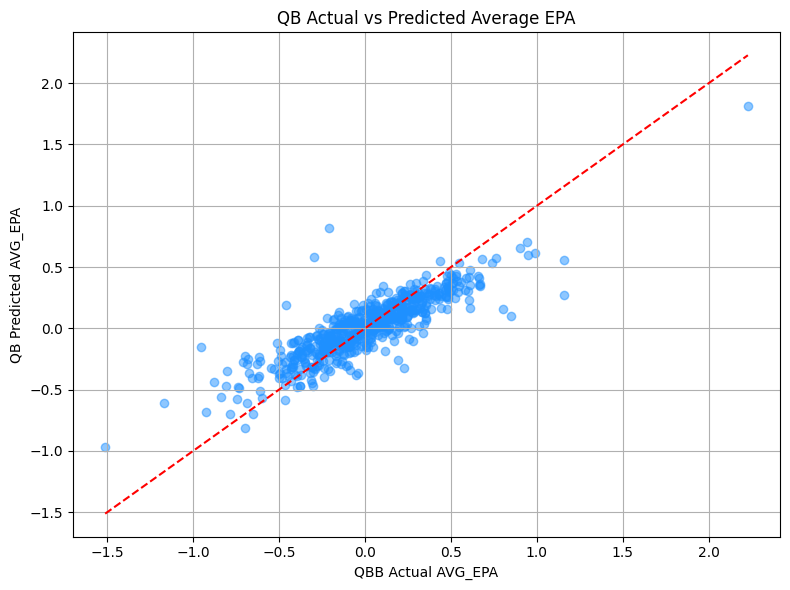

In [144]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_qb, y_pred_qb, alpha=0.5, color='dodgerblue')
plt.plot([y_test_qb.min(), y_test_qb.max()], [y_test_qb.min(), y_test_qb.max()], '--r')  # 1:1 line
plt.xlabel("QBB Actual AVG_EPA")
plt.ylabel("QB Predicted AVG_EPA")
plt.title("QB Actual vs Predicted Average EPA")
plt.grid(True)
plt.tight_layout()
plt.show()


## XGBoost

In [147]:
from xgboost import XGBRegressor

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Instantiate model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Grid Search with 5-fold CV
grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit
grid.fit(X_train_qb, y_train_qb)

# Results
print("Best Parameters:", grid.best_params_)
print("Best RMSE Score:", -grid.best_score_)

# Best model
best_xgb = grid.best_estimator_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\Andy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast


Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Best RMSE Score: 0.21572448678219014
